In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3

2022-11-15 10:57:59.124418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 10:57:59.240936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-11-15 10:57:59.240961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 10:57:59.267089: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 10:58:00.1585

In [20]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(422574, 6)
['Macrophages' 'B cells' 'NK cells' 'Monocytes' 'Dendritic cells'
 'T cells' 'Stromal cells']


gene    scores     pvals  clusterId key     cellType
0    STRADB  1.970233  0.050047          1  ND  Macrophages
1      E2F8  1.969810  0.050184          1  ND  Macrophages
2      EDC3  1.969013  0.050110          1  ND  Macrophages
3  SLC25A20  1.968786  0.050065          1  ND  Macrophages
4     ATP7A  1.968395  0.050189          1  ND  Macrophages

In [6]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

adata = {}

for f in os.listdir(dirPath):
    
    if not f == "all":
        key = f
        mtxPath = f"{dirPath}{f}/outs/"
        data = sc.read_visium(mtxPath)
        data.var_names_make_unique()
        data.var_names = [x.upper() for x in data.var_names]
        adata[key] = data
    
adata.keys()

reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD14/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/ND/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD8/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['HFD14', 'ND', 'HFD8'])

# Filtering

In [7]:
keys = ['ND', 'HFD8', 'HFD14']

min_counts = 10

for key in keys:
    print(key)
    data = adata[key]
    sc.pp.filter_cells(data, min_counts=min_counts)
    sc.pp.normalize_total(data, target_sum=1e4) # Normalize each cell by total counts over all genes
    sc.pp.log1p(data) # Logarithmize data via `X = \log(X + 1)`,
    sc.pp.scale(data) # unit variance and zero mean


ND
filtered out 1 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD8
filtered out 2 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD14
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


ND


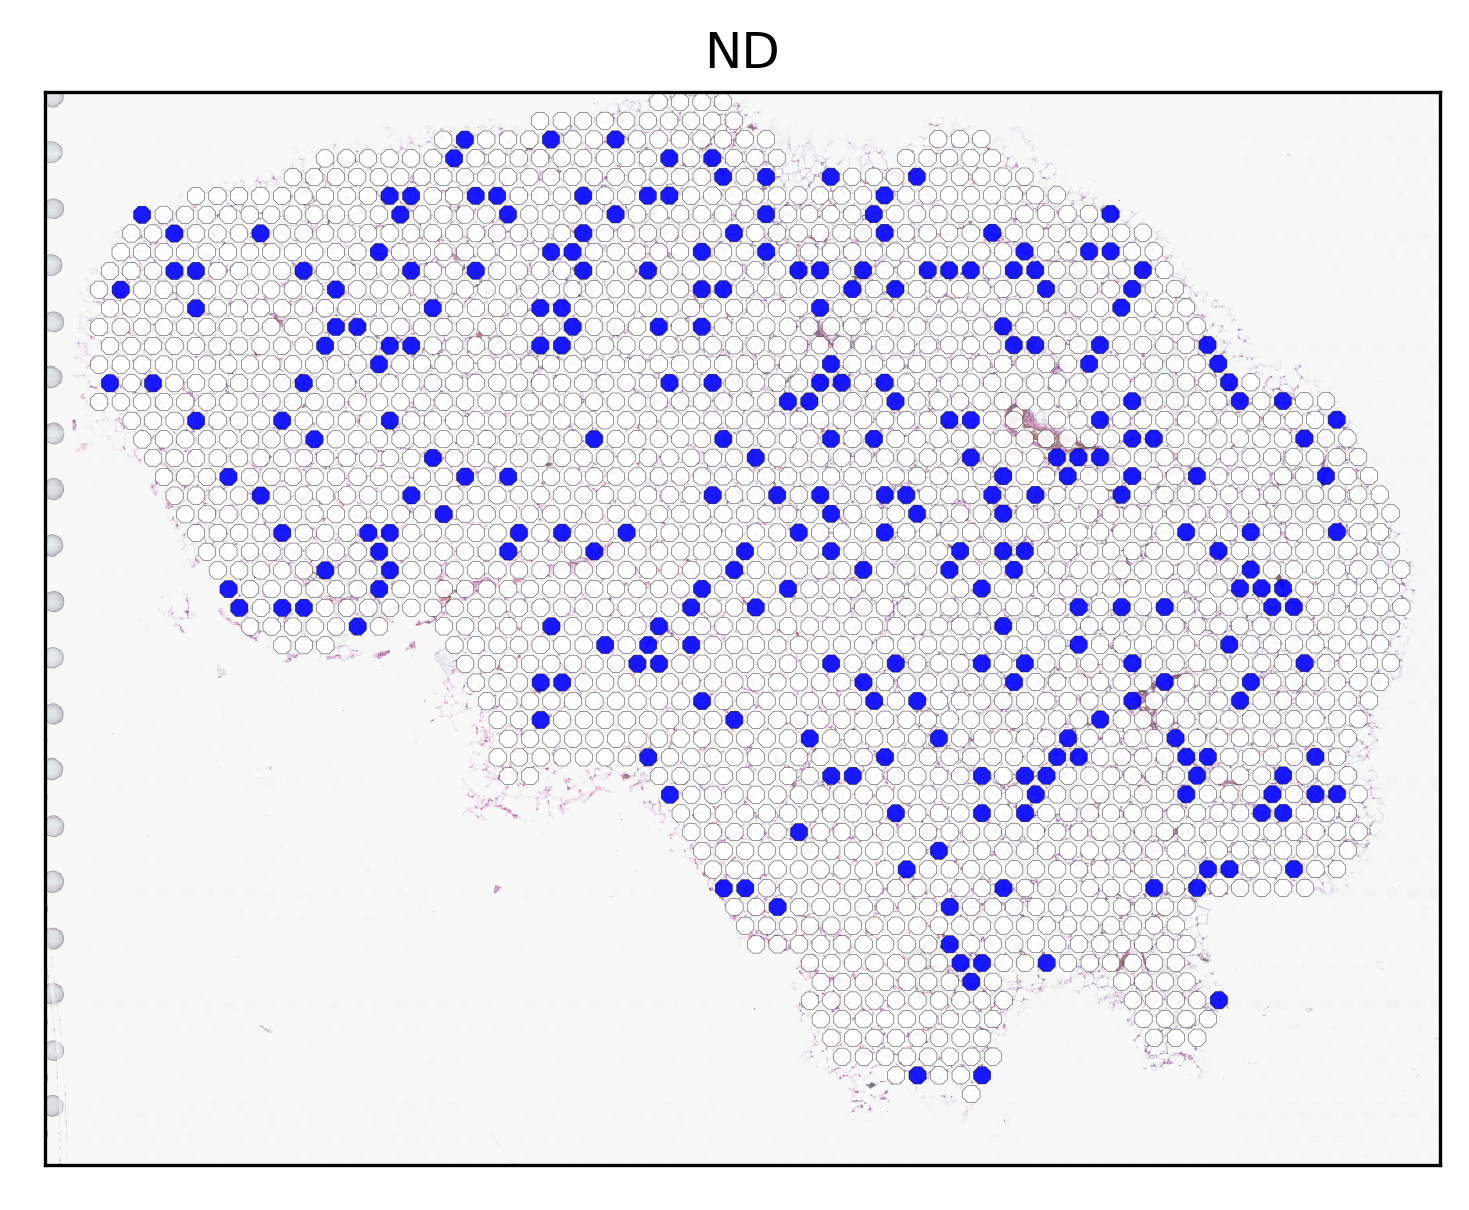

HFD8


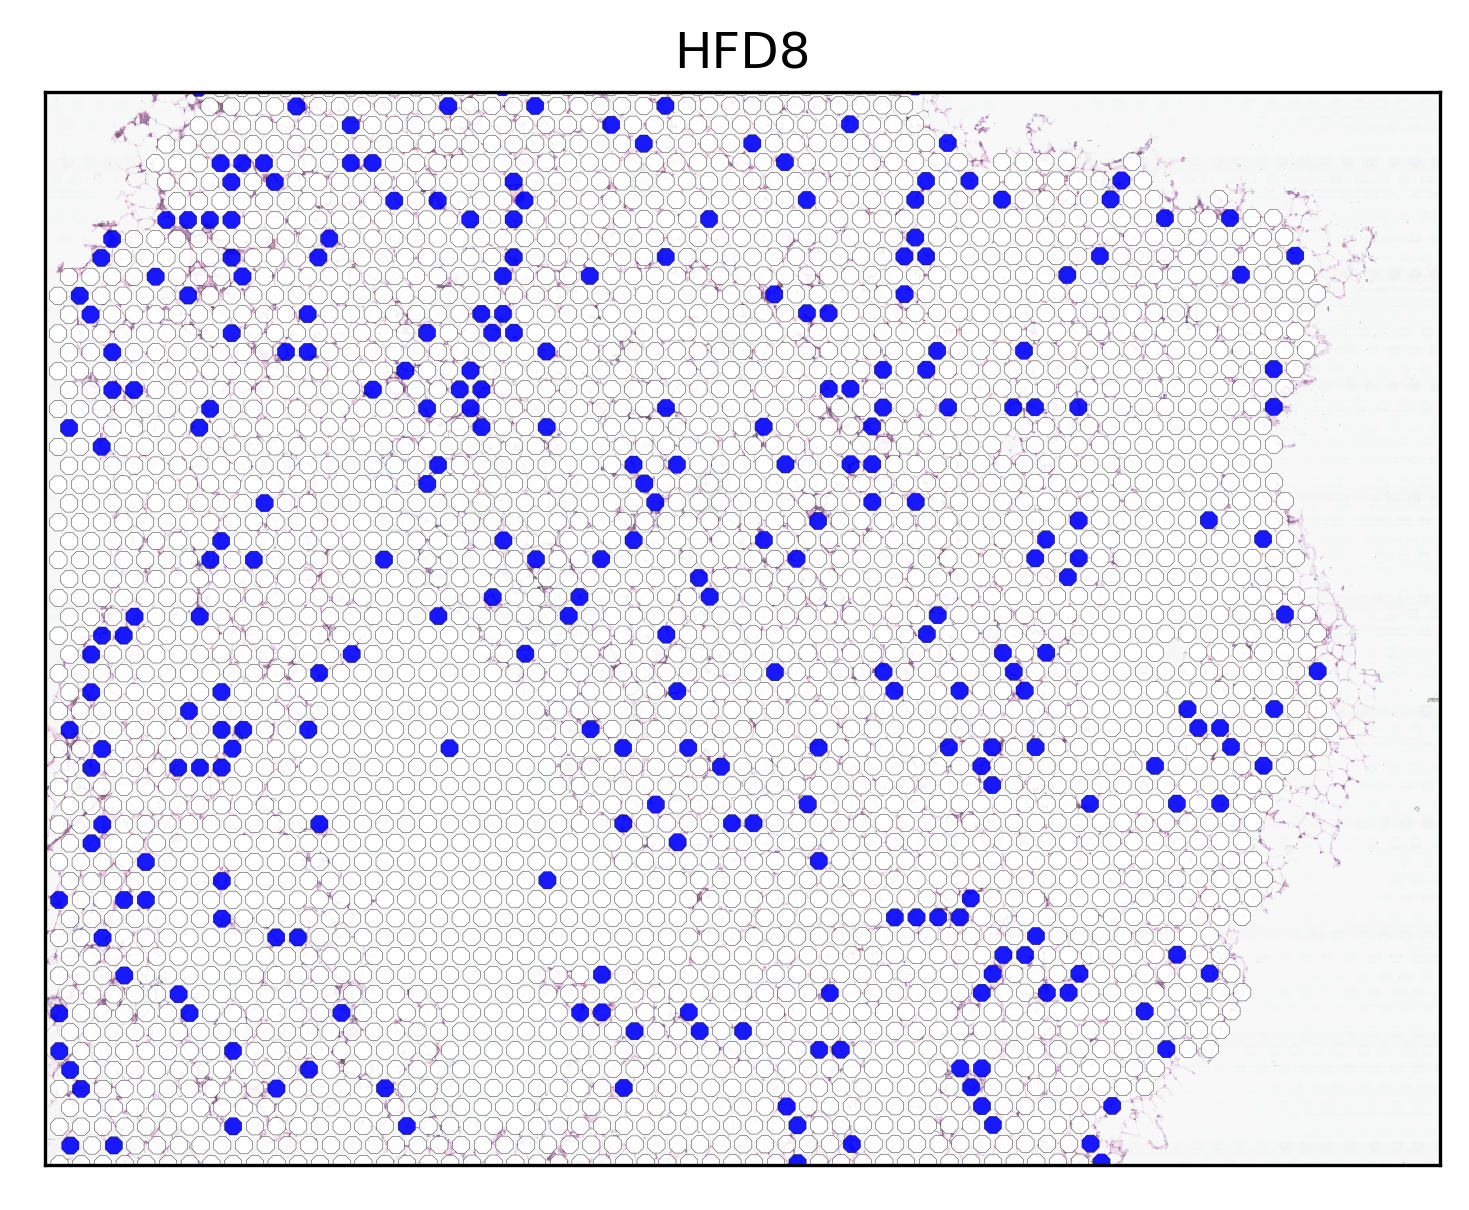

HFD14


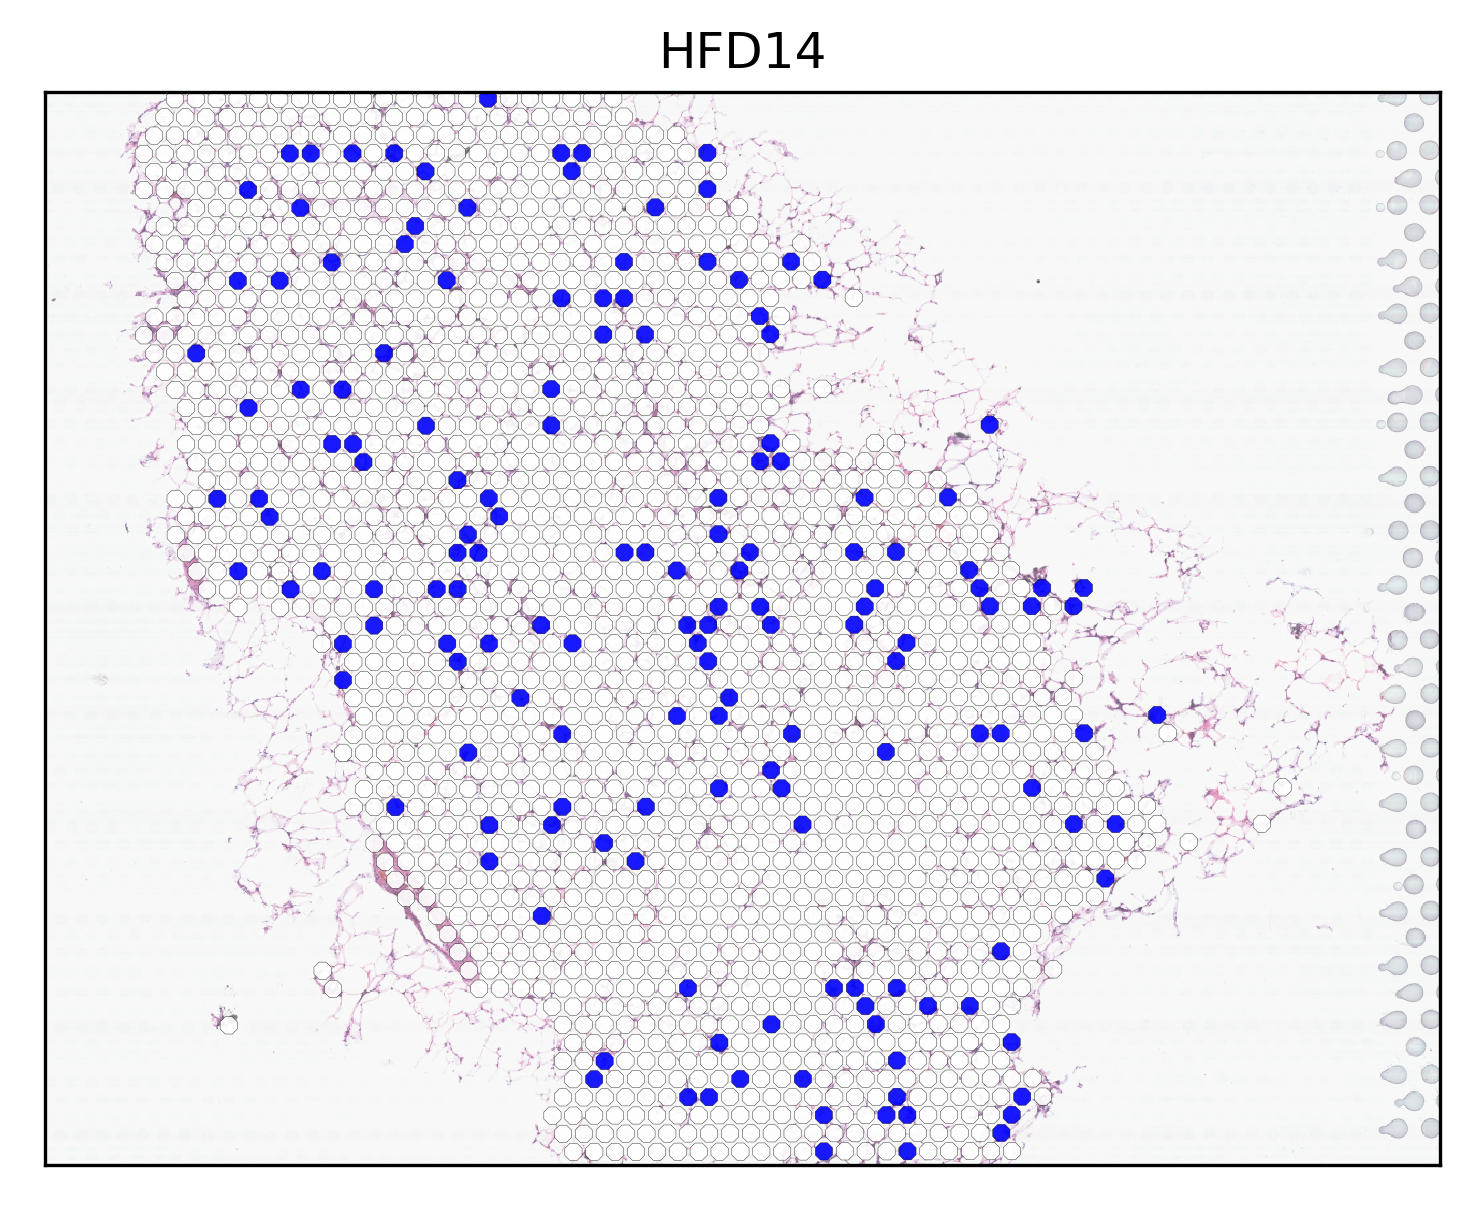

In [40]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

ctype = 'Macrophages'
topN = 10

def getImage(data):
    """A function to get image from the spatial data """
    from scanpy.pl._tools import scatterplots as spt    
    sptData = data.uns['spatial']
    
    libraryId = list(sptData.keys())[0]
    sptData = sptData[libraryId]
    
    # get params
    img = sptData['images']['hires']
    scale_factor = sptData['scalefactors']['tissue_hires_scalef']
    return img, scale_factor


for key in keys:
    print(key)
    data = adata[key]

    # get the image and the scale factors
    img, scale_factor = getImage(data)
    
    # get the data
    df = data.to_df()
    
    # get genes for cell types
    tf = cf[(cf['cellType'] == ctype) & (cf['key'] == key)]
    
    # sort 
    tf = tf.sort_values(by='scores', ascending=False)
    
    genes = tf['gene'].head(topN).to_list()
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    color = df[genes].mean(axis=1)
    color = np.where(color > 0, "b", "w")

    # plot the spots
    plt.scatter(x, 
                y,
                # c=np.log(df[genes].mean(axis=1)),
                c=color,
                marker="8",
                edgecolor="k",
                lw=0.1,
                # cmap='Reds',
                zorder=2,
                alpha=0.9,
                s=20)
    
    # plot the plate
    plt.imshow(img.astype(float), 
               interpolation='none',
               cmap='binary',
               alpha=0.7,
               zorder=1)
    
    ax = plt.gca()
    ax.set_xlim(200, 1500)
    ax.set_ylim(1650, 650)
    ax.set_aspect("equal")
    ax.set_title(key)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()
    
    # break